<a id='introduction'></a>
## Introduction

This example showcases the use of the XAITK-Saliency API to generate visual saliency maps, specifically using the [scikit-learn](https://scikit-learn.org/stable/) library and the MNIST dataset.
The MNIST dataset contains grayscale images of handwritten digits (0-9) which are normalized and centered in the frame. It was developed to evaluate the performance models on the classification of individual handwritten digits.

[This example](https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html) from scikit-learn's website uses their `LogisticRegression` class to achieve farily high accuracy on the MNIST dataset with very short training time.
As is shown by this example, it is easy to visualize the decision bounaries of each class by simply plotting their respective model's coefficients in the same dimensions as the input image.

However, if we want to achieve higher accuracy with a non-linear model, like in this [other example](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html#sphx-glr-auto-examples-neural-networks-plot-mnist-filters-py) from scikit-learn that uses an `MLPClassifier`, visualization is not so simple.
Here it is shown that you can visualize the weights of the MLP as images, but these images only show generic paterns that the model has learned.
The behavior of each class is still obscure.
This also requires knowledge of the intrinsic properties of the classification model being used.

Building upon the this second example, we take the MLP used and create saliency heatmaps that describe its behvaior on individual examples from the MNIST dataset, as well as heatmaps that show the decision boundaries of each class. Our approach requires no knowledge of how the MLP classifier, unlike both example discussed above. However, generation of saliency maps through this blackbox approach involve much more computation.

## Downloading the Dataset

The MNIST dataset consists of 70000 28x28 grayscale images of handwritten numbers.
Each image is stored as a column vector, resulting in a (70000,784) shape for the entire dataset.

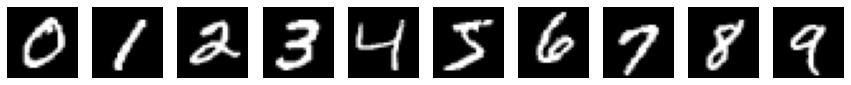

In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = X/X.max()

# Find examples of each class
ref_inds = []
for i in range(10):
    ref_inds.append(np.where(np.int64(y) == i)[0][0])
    
ref_imgs = X[ref_inds]

# Plot examples
plt.figure(figsize=(15,5))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(ref_imgs[i].reshape(28, 28), 'gray')
    plt.axis('off')
    

## Fitting the Model

Following the [example](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html#sphx-glr-auto-examples-neural-networks-plot-mnist-filters-py) from scikit-learn, we traing an `MLPClassifier` on the MNIST dataset using the same hyperparameters.
As such, this code is directly taken from their page.

To shorten training time, the MLP has only one hidden layer with 50 nodes, and is only trained for 10 iterations, meaning the model does not converge.

Some discernable patterns are visible in the resulting weight visualizations, but this information does not directly tell us how the model classifies on a per-image or per-class level.

Iteration 1, loss = 0.32009978
Iteration 2, loss = 0.15347534
Iteration 3, loss = 0.11544755
Iteration 4, loss = 0.09279764
Iteration 5, loss = 0.07889367
Iteration 6, loss = 0.07170497
Iteration 7, loss = 0.06282111
Iteration 8, loss = 0.05530788
Iteration 9, loss = 0.04960484
Iteration 10, loss = 0.04645355
Training set score: 0.986800
Test set score: 0.970000


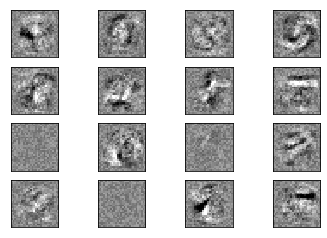

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier

# use the traditional train/test split
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, random_state=1,
                    learning_rate_init=.1)

# this example won't converge because of CI's time constraints, so we catch the
# warning and are ignore it here
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning,
                            module="sklearn")
    mlp.fit(X_train, y_train)

print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

fig, axes = plt.subplots(4, 4)
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()
for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

## The "Application"

We can use the `XAITK-Saliency` high-level API to generate saliency maps that will give us some insight on what this MLP model has learned.

Our "application" will accept a set of images, a blackbox image classifier, and a saliency generator and will generate saliency maps for each image provided.
The saliency maps from the first image in the set will then be plotted to give us an idea of the models decision making on a single sample.

Additionally, because all digits in the MNIST dataset are centered in the frame, we can average all the heatmaps generated for each respective class to produce a decision boundary visualization.
The application will do just that and plot the resulting averaged heatmap for each digit class.
This should compare to what is possible with a linear model as shown in the first [scikit-example](https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html) discussed in the [indtroduction](#introduction)

In [3]:
from smqtk_classifier import ClassifyImage
from xaitk_saliency import GenerateImageClassifierBlackboxSaliency
from functools import reduce
from math import ceil

def app(
    images: np.ndarray,
    image_classifier: ClassifyImage,
    saliency_generator: GenerateImageClassifierBlackboxSaliency
):  

    # Generate saliency maps
    sal_maps_set = []
    for img in images:
        ref_image = img.reshape(28, 28)
        sal_maps = saliency_generator(ref_image, image_classifier)
        sal_maps_set.append(sal_maps)
    
    num_classes = sal_maps_set[0].shape[0]
    
    # Plot first image in set with saliency maps
    plt.figure(figsize=(10,5))
    plt.suptitle("Heatmaps for First Image", fontsize=16)
    num_cols = ceil(num_classes/2) + 1
    plt.subplot(2, num_cols, 1)
    plt.imshow(images[0].reshape(28,28), cmap='gray')
    plt.xticks(())
    plt.yticks(())
    
    for c in range(num_cols - 1):
        plt.subplot(2, num_cols, c + 2)
        plt.imshow(sal_maps_set[0][c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)
        plt.xticks(())
        plt.yticks(())
        plt.xlabel(c)
    for c in range(num_classes - num_cols + 1, num_classes):
        plt.subplot(2, num_cols, c + 3)
        plt.imshow(sal_maps_set[0][c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)
        plt.xticks(())
        plt.yticks(())
        plt.xlabel(c)
    
    # Average heatmaps for each respective class
    global_maps = reduce(np.add, sal_maps_set) / len(images)
    
    # Clip and scale positive maps for easy visualization
    global_maps_pos = np.clip(global_maps, 0, 1)
    for i in range(len(global_maps_pos)):
        global_maps_pos[i] = global_maps_pos[i] / global_maps_pos[i].max()
    
    # Plot average maps
    plt.figure(figsize=(10, 5))
    plt.suptitle("Average Heatmaps from All Images", fontsize=16)
    for i in range(num_classes):
        plt.subplot(2, ceil(num_classes/2), i + 1)
        plt.imshow(global_maps_pos[i], cmap=plt.cm.RdBu, vmin=-1, vmax=1)
        plt.xticks(())
        plt.yticks(())
        plt.xlabel(i)

## Blackbox Classifier

Here we wrap our `MLPClassifier` in a [SMQTK-Classifier's](https://smqtk-classifier.readthedocs.io/en/stable/classifier_interfaces.html#classifyimage) `ClassifyImage` class to comply with the API's interface.

In [4]:
class MNISTClassifier (ClassifyImage):
    def get_labels(self):
        return [i for i in range(10)]
    
    def classify_images(self, image_iter):
        
        # Convert image set back to column vector form
        images = np.array([]).reshape(0, 28*28)
        for img in image_iter:
            images = np.vstack((images, img.reshape(1, -1)))
        
        return iter(mlp.predict_proba(images))
            
    # Required for implementation
    def get_config(self):
        return {}
    
image_classifier = MNISTClassifier()

## Heatmap Generation

We create an instance of `SlidingWindowStack`, an implementation of the `GenerateImageClassifierBalckboxSaliency` interface, to carry out our image perturbation and heatmap generation. Because each image is so small, we perturbate on a per-pixel basis to create high detail saliency maps.

In [5]:
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.slidingwindow import SlidingWindowStack

gen_slidingWindow = SlidingWindowStack(
    window_size=(1, 1),
    stride=(1, 1),
    threads=4
)

## Calling the Application

Finally, we call the application using the first 20 images in the MNIST dataset. Here the blue is showing positive saliency while the red is showing negative.

Even with a small set of images, the general shape of most the digits is visible. Using a larger set of images would improve the visible boundary, but scales the computation time linearly.

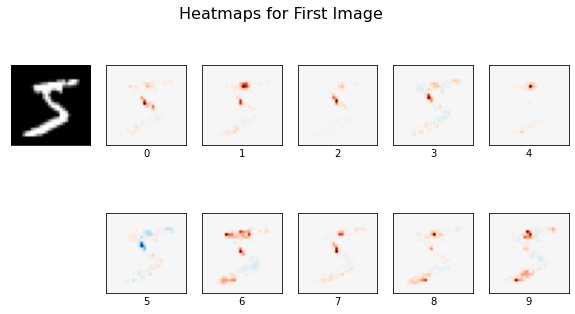

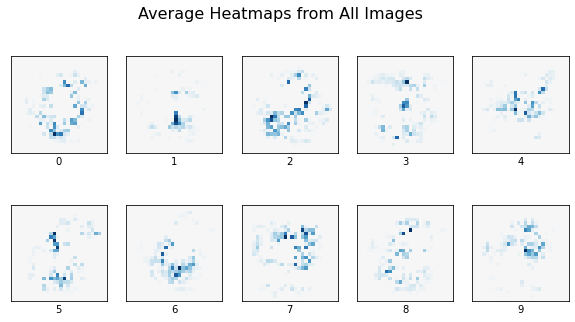

In [6]:
app(
    X[0:20],
    image_classifier,
    gen_slidingWindow
)